In [46]:
import pandas as pd
import helpers as h
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
reload(h)

# Global settings
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('ggplot') # nicer plots
pd.set_option('display.max_columns', None)

X_train, y_train, X_val, y_val, X_test, y_test, X_train_val, y_train_val, train_idx, train_wval_idx, val_idx, test_idx, df, feature_names, participants = h.prepare_datasets('output/combined_feature_engineered_tnt_only_win8.csv', test_size=0.1, val_size=0.1) 

assert len(feature_names) == X_train.shape[1]

Training set: 2158 rows of features, 2158 labels
Validation set: 288 rows of features, 288 labels
Training + Validation set: 2446 rows of features, 2446 labels
Test set: 122 rows of features, 122 labels


## Base model

F1 Score (micro): 0.90
AUCPR: 0.10
AUC: 0.50


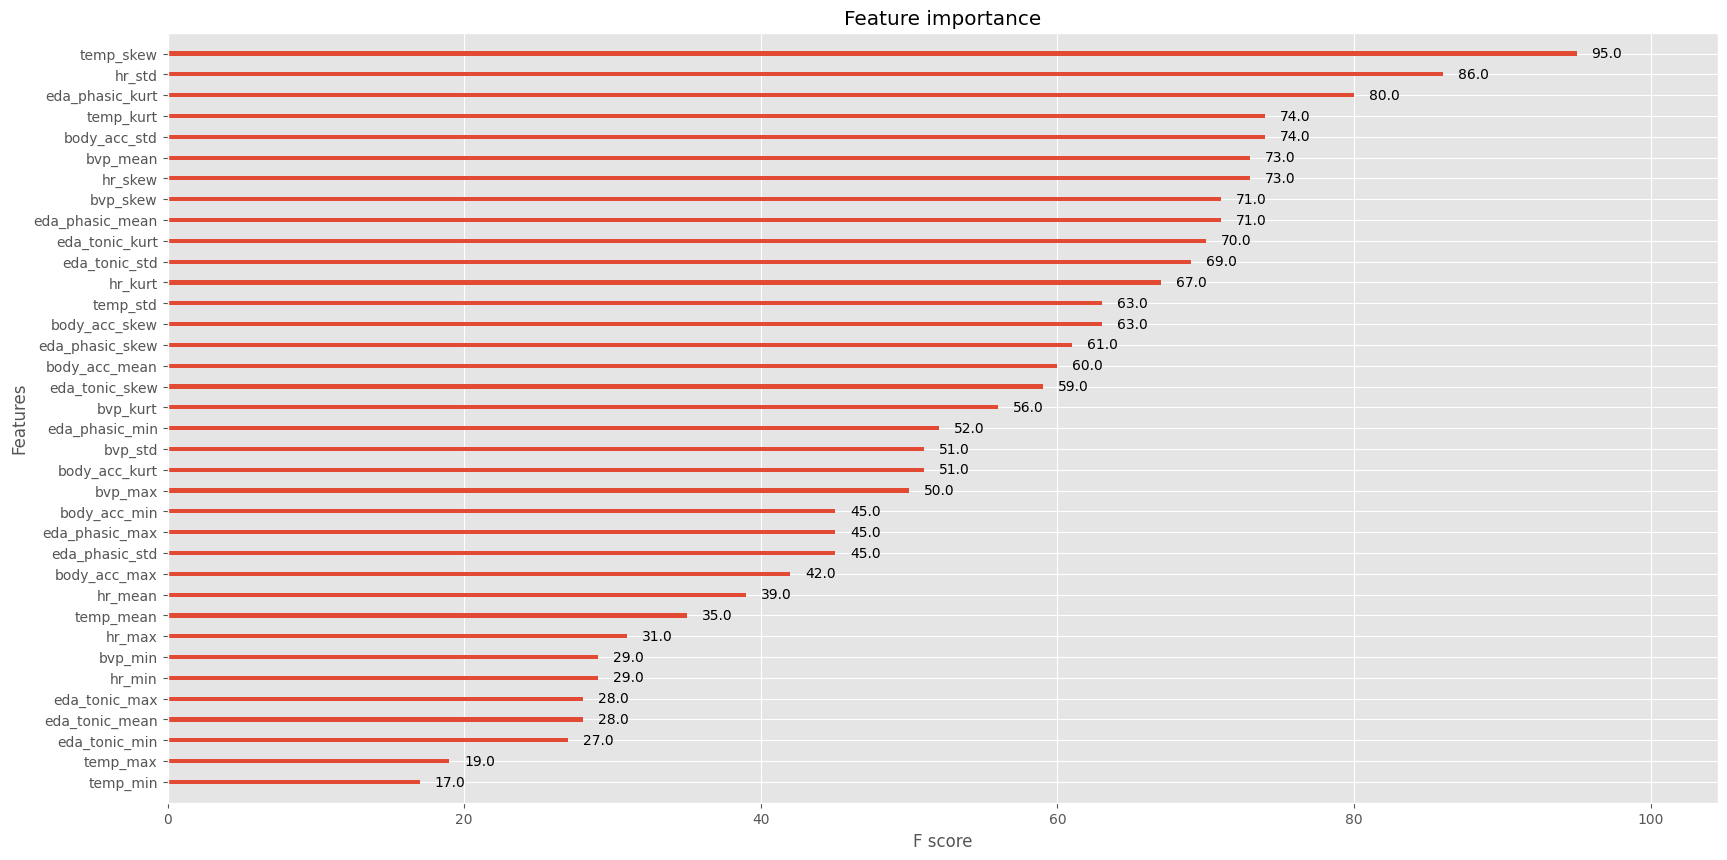

In [47]:
import xgboost as xgb

# Initialize an XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = model.predict(X_val)

# Evaluate the model
report, string = h.get_eval(y_val, y_pred)
print(string)

xgb.plot_importance(model)
plt.show()

# Bayesian Hyperparameter Optimisation

## Sequential optimisation and cross-validation

In [61]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.metrics import f1_score

# Define the hyperparameter space
counts = y_train.value_counts()
scale_pos_weight = counts[0] / counts[1] # Recommended by: https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9&sca_esv=254eb9c569a53dbc&strip=1&vwsrc=0

# Default recommendations: https://bradleyboehmke.github.io/xgboost_databricks_tuning/tutorial_docs/xgboost_hyperopt.html
space = {
    'objective':'binary:logistic',
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype=int)),
    'min_child_weight': hp.uniform('min_child_weight', 0.1, 15),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1),
    'n_estimators': hp.choice('n_estimators', range(50, 5000)),
    'gamma': hp.choice('gamma', [0, hp.loguniform('gamma_log', np.log(1), np.log(1000))]),
    'reg_lambda': hp.choice('gamma', [0, hp.loguniform('gamma_log', np.log(1), np.log(1000))]),
    'reg_alpha': hp.choice('gamma', [0, hp.loguniform('gamma_log', np.log(1), np.log(1000))]),
    'scale_pos_weight': scale_pos_weight
}

In [62]:
# Define the objective function to minimize
from sklearn.metrics import average_precision_score

def objective(params):
    xgb_model = xgb.XGBClassifier(**params, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    score = average_precision_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

num_boost_round = best_params.pop('n_estimators', None)

100%|██████████| 100/100 [00:51<00:00,  1.96trial/s, best loss: -0.11340048840048841]
Best set of hyperparameters:  {'colsample_bytree': 0.9251041475478636, 'learning_rate': 0.02393711691301259, 'max_depth': 1, 'n_estimators': 12, 'reg_alpha': 4.065062263658539, 'reg_lambda': 1.4527101009228396, 'subsample': 0.7021950131826659}


In [63]:
# Train the model with the best hyperparameters using cross-validation
reload(h)

# Recombine the training and validation sets for cross-validation
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Create a DMatrix
dmatrix = xgb.DMatrix(data=X_train_val, label=y_train_val)

folds = h.create_folds(X_train_val, y_train_val, df.loc[train_idx, 'participant'])

# Check the lengths of the train/test splits
for tr_idx, te_idx in folds:
    print(f"Train length: {len(tr_idx)}, Test length: {len(te_idx)}. Total: {len(tr_idx) + len(te_idx)}")

# Check the length of dmatrix
print(f"DMatrix length: {dmatrix.num_row()}")

print('\nCross-validation results:')

cv_results = xgb.cv(params=best_params, dtrain=dmatrix, num_boost_round=num_boost_round, folds=folds, metrics=['auc', 'aucpr'], custom_metric=h.xgb_aucpr, early_stopping_rounds=10, seed=1337)

# Print cv_results
print(f"AUCPR: {cv_results['test-aucpr-mean'].iloc[-1]}")
print(f"AUC: {cv_results['test-auc-mean'].iloc[-1]}")

Folds created:
Train: 1966, Eval: 480
Train: 2085, Eval: 361
Train: 2125, Eval: 321
Train: 2243, Eval: 203
Train: 2254, Eval: 192
Train: 2256, Eval: 190
Train: 2257, Eval: 189
Train: 2300, Eval: 146
Train: 2274, Eval: 172
Train: 2254, Eval: 192
Train length: 1966, Test length: 480. Total: 2446
Train length: 2085, Test length: 361. Total: 2446
Train length: 2125, Test length: 321. Total: 2446
Train length: 2243, Test length: 203. Total: 2446
Train length: 2254, Test length: 192. Total: 2446
Train length: 2256, Test length: 190. Total: 2446
Train length: 2257, Test length: 189. Total: 2446
Train length: 2300, Test length: 146. Total: 2446
Train length: 2274, Test length: 172. Total: 2446
Train length: 2254, Test length: 192. Total: 2446
DMatrix length: 2446

Cross-validation results:
AUCPR: 0.15320838397170927
AUC: 0.4884230639328767


## Parallel optimisation and cross-validation

In [27]:
reload(h)
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, STATUS_OK
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
# https://stackoverflow.com/questions/43005864/xgboost-cv-with-custom-folds-python?rq=3 

folds = h.create_folds(X_train_val, y_train_val, df.loc[train_idx, 'participant'])

print('\nCross-validation results:')
# Define the objective function to minimize
def objective(params):
    try:
        dmatrix = xgb.DMatrix(data=X_train_val, label=y_train_val)
        cv_results = xgb.cv(params=params, dtrain=dmatrix, num_boost_round=num_boost_round, folds=folds, metrics=['auc', 'aucpr'], custom_metric=h.xgb_aucpr, early_stopping_rounds=10, seed=1337)
        loss = cv_results["test-aucpr-mean"].iloc[-1]
        return {'loss': -loss, 'status': STATUS_OK}
    except Exception as e:
        return {'loss': float('inf'), 'status': STATUS_OK, 'exception': str(e)}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

Folds created:
Train: 1605, Eval: 361
Train: 1645, Eval: 321
Train: 1763, Eval: 203
Train: 1774, Eval: 192
Train: 1776, Eval: 190
Train: 1777, Eval: 189
Train: 1820, Eval: 146
Train: 1850, Eval: 116
Train: 1814, Eval: 152
Train: 1870, Eval: 96

Cross-validation results:
100%|██████████| 100/100 [00:31<00:00,  3.19trial/s, best loss: inf]
Best set of hyperparameters:  {'colsample_bytree': 0.9072113649141799, 'learning_rate': 0.013964322884584036, 'max_depth': 0, 'n_estimators': 246, 'reg_alpha': 3.223602033208444, 'reg_lambda': 2.7042454554511233, 'subsample': 0.7310919162693674}


F1 Score (micro): 0.85
AUCPR: 0.15
AUC: 0.50


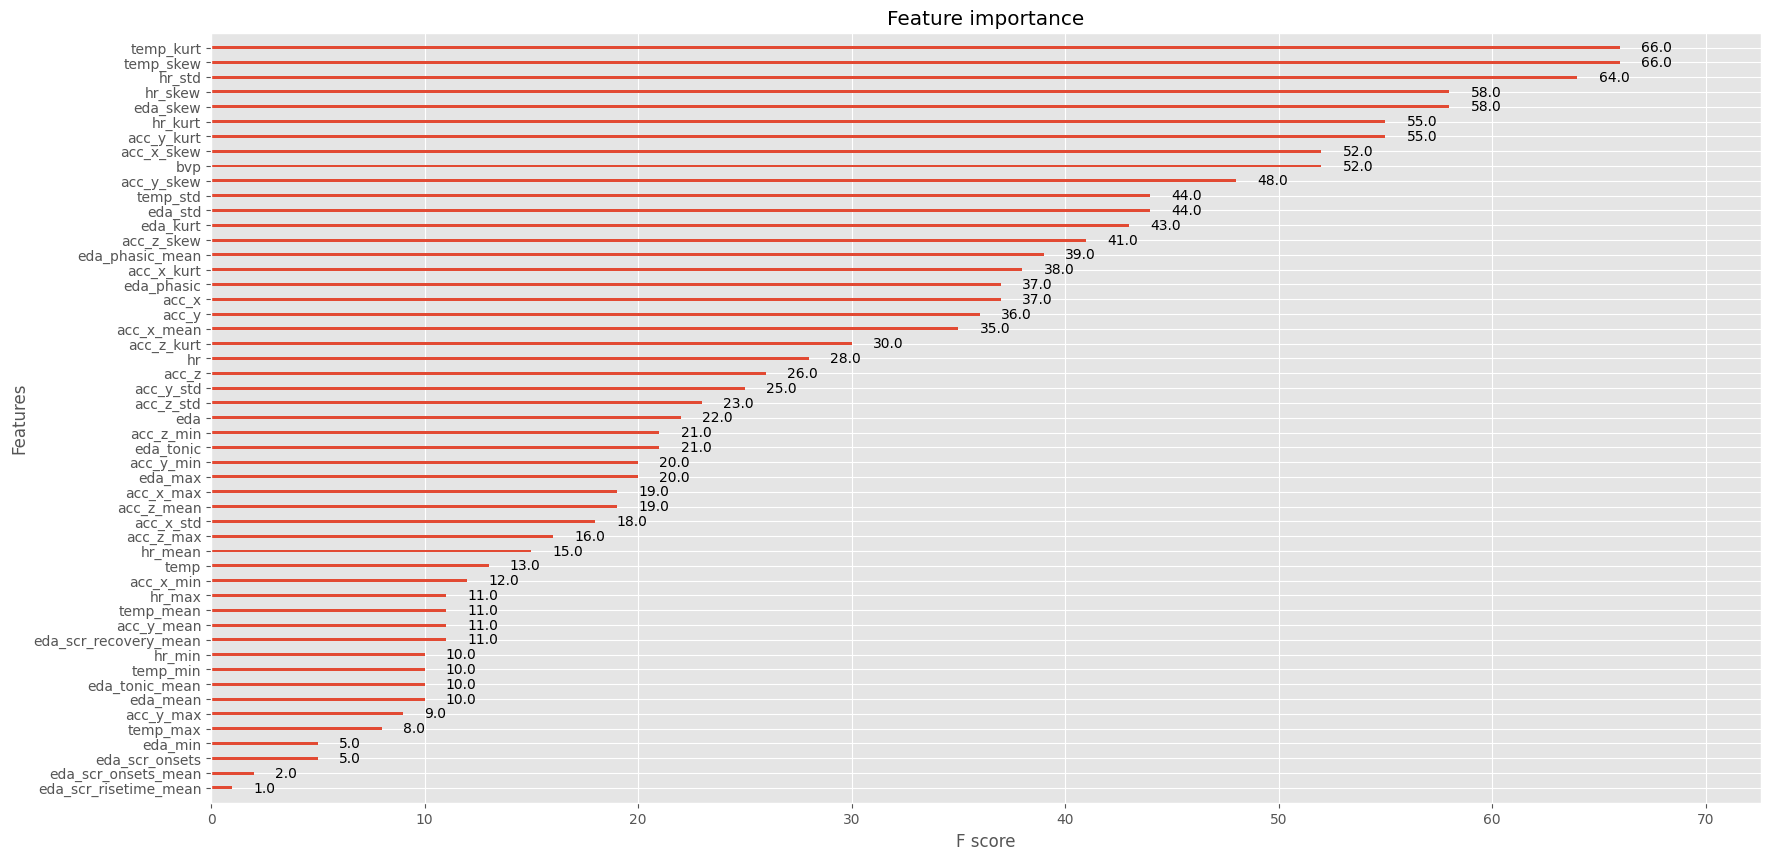

In [28]:
best_model = xgb.XGBClassifier(**best_params, objective='binary:logistic', random_state=42)
best_model.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = best_model.predict(X_val)

# Evaluate the model
report, string = h.get_eval(y_val, y_pred)
print(string)

xgb.plot_importance(model)
plt.show()

# Shap-hypetune: combined hyperparameter optimisation (Bayesian) and feature selection (SHAP)

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/shap-for-feature-selection-and-hyperparameter-tuning-a330ec0ea104&sca_esv=6246709ce63302d6&strip=1&vwsrc=0

## Base

In [4]:
### HYPERPARAM TUNING WITH HYPEROPT + RECURSIVE FEATURE ADDITION (RFA) SHAP ###
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

from sklearn.model_selection import GroupKFold
from hyperopt import hp, Trials
from xgboost import *
from shaphypetune import BoostRFA
import numpy as np

# Initialize an XGBoost classifier
clf_xgb = XGBClassifier(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1)

# Initialize the BoostRFA model
model = BoostRFA(
    clf_xgb, param_grid=space, min_features_to_select=1, step=1,
    n_iter=8, sampling_seed=0,
    importance_type='shap_importances', train_importance=False
)

# Fit the model
model.fit(
    X_train, y_train, trials=Trials(), 
    eval_set=[(X_val, y_val)], early_stopping_rounds=6, verbose=1,
    eval_metric=h.xgb_aucpr
)

model.estimator_, model.best_params_, model.best_score_, model.n_features_
 


8 trials detected for ('objective', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'n_estimators', 'reg_lambda', 'reg_alpha', 'scale_pos_weight')

trial: 0001 ### iterations: 00005 ### eval_score: -0.16684
trial: 0002 ### iterations: 00000 ### eval_score: -0.17946
trial: 0003 ### iterations: 00000 ### eval_score: -0.16771
trial: 0004 ### iterations: 00000 ### eval_score: -0.13954
trial: 0005 ### iterations: 00002 ### eval_score: -0.13483
trial: 0006 ### iterations: 00001 ### eval_score: -0.11169
trial: 0007 ### iterations: 00000 ### eval_score: -0.13016
trial: 0008 ### iterations: 00000 ### eval_score: -0.1017


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9011216346265931, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.010659123016812678,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=274, n_jobs=-1,
               num_parallel_tree=None, random_state=0, ...),
 {'colsample_bytree': 0.9011216346265931,
  'learning_rate': 0.010659123016812678,
  'max_depth': 9,
  'n_estimators': 274,
  'objective': 'binary:logistic',
  'reg_alpha': 3.4908390105177474,
 

F1 Score (micro): 0.66
AUCPR: 0.09
AUC: 0.46


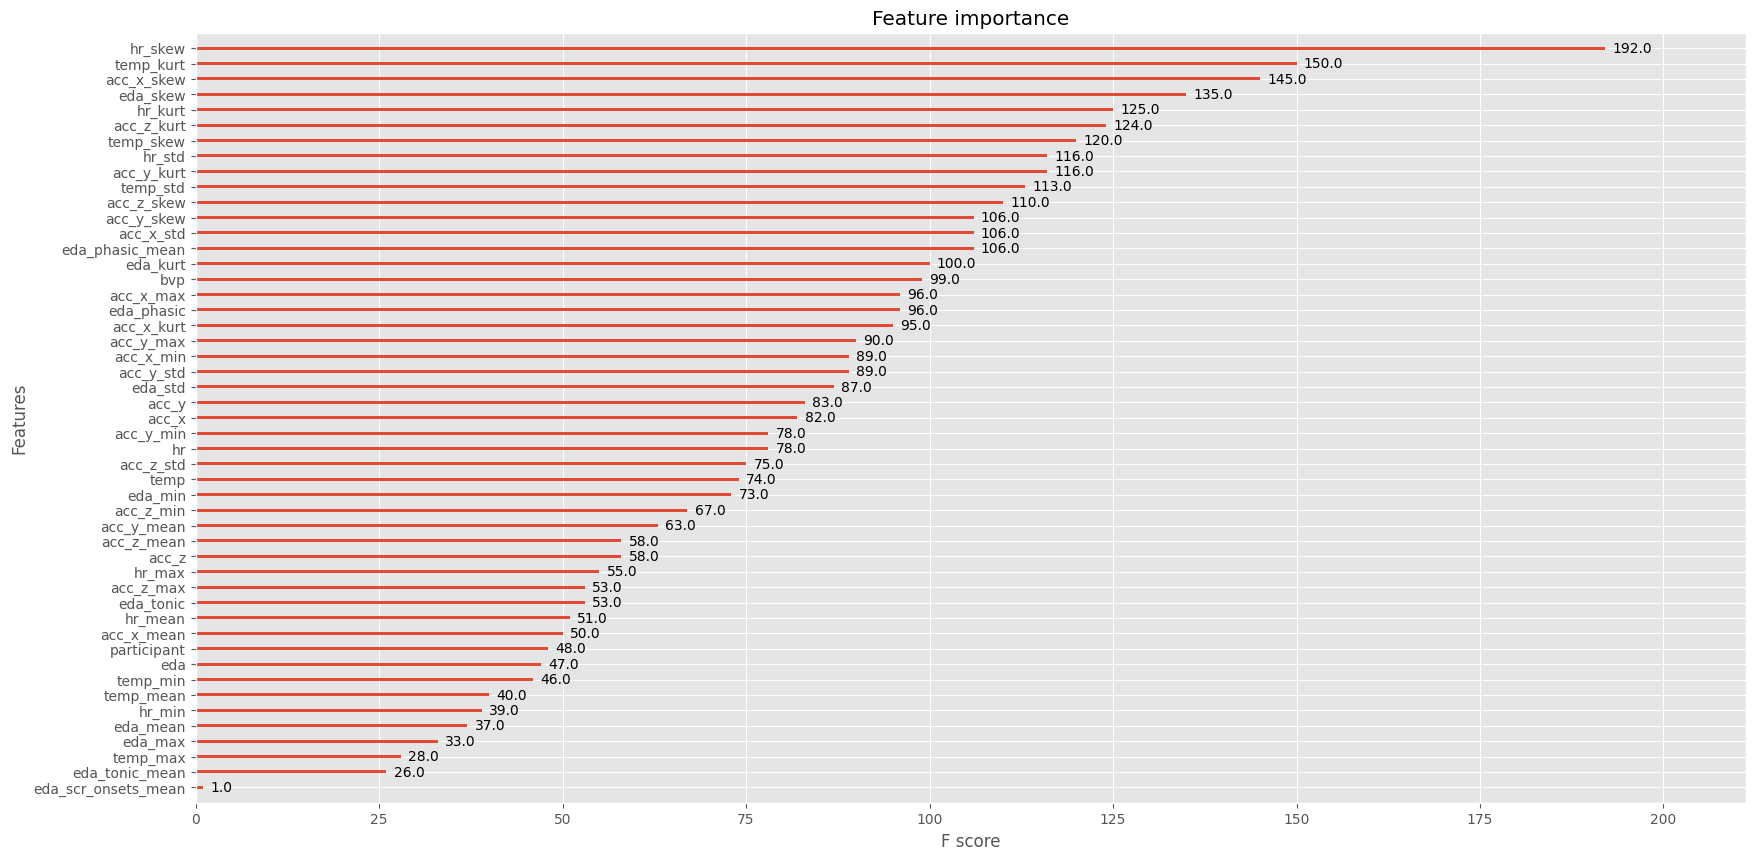

In [72]:
# Fit the model on the combined training and validation data
model.estimator_.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = model.estimator_.predict(X_val)

# Evaluate the model
report, string = h.get_eval(y_val, y_pred)

print(string)

xgb.plot_importance(model.estimator_)
plt.show()

Getting an F1-score of 0.00, meaning that the classifier has learned to not predict the 1 class at all.

### Applying shap-hypetune to SMOTE-resampled data

https://github.com/cerlymarco/shap-hypetune/issues/1#issuecomment-877585945